*2025.08.13*

测试搜索树可视化

In [1]:
import sys

sys.path.append('../')

In [2]:
from dotenv import load_dotenv
import os

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_milvus import Milvus, BM25BuiltInFunction
from langgraph.checkpoint.memory import MemorySaver

from rag_with_judge.workflow import get_rag_with_judge_workflow
from modules.retriever import Retriever

load_dotenv()

llm = ChatOpenAI(
    api_key=os.getenv("BL_API_KEY"),
    base_url=os.getenv("BL_BASE_URL"),
    model='qwen-max-latest',
    # model='qwen-max-2025-01-25',
    # model='qwen2.5-7b-instruct',  # 小模型会有同样的效果吗  ->  不太好
    temperature=0.0
)

embed_model = OpenAIEmbeddings(
    api_key=os.getenv("BL_API_KEY"),
    base_url=os.getenv("BL_BASE_URL"),
    model="text-embedding-v3",
    dimensions=1024,
    check_embedding_ctx_length=False
)

vector_store = Milvus(
    collection_name='hybrid_hotpotqa500_hnsw',
    embedding_function=embed_model,
    builtin_function=BM25BuiltInFunction(output_field_names='sparse'),
    vector_field=['dense', 'sparse']
)

# 获得带有短期记忆的 RAG with Judge 图
memory = MemorySaver()
rag_with_judge_wf = get_rag_with_judge_workflow()
rag_with_judge = rag_with_judge_wf.compile(checkpointer=memory)

# 定义检索器
rrf_retriever = Retriever(
    vector_store=vector_store,
    topk=3,
    search_fields=['dense', 'sparse'],
    search_type='hybrid',
    search_params=[
        {'metric_type': 'L2', 'params': {'ef': 21}},
        {'params': {'drop_ratio_search': 0.2}}
    ],
    ranker_type='rrf',
    ranker_params={'k': 60}
)

# 定义运行时配置
config = {
    'configurable': {
        'retriever': rrf_retriever,
        'llm': llm,
        'thread_id': '1',
        'graph': rag_with_judge,
        'recursion_depth': 0,
        'max_rec_depth': 3
    }
}

In [3]:
query = 'Which suburb of Adelaide in the City of Norwood Payneham St Peters is included in the electoral district of Dunstan?'

res = rag_with_judge.invoke(
    input={'query': query},
    config=config
)

使用 0a5fe1ad-1472-43c9-9891-0b83024b5875 调用 RAG，问题为 Which electoral district includes the suburb of St Peters?，当前递归深度为 1使用 d0580491-90de-488d-8367-892ef2a2bacb 调用 RAG，问题为 Which suburbs in the City of Norwood Payneham St Peters are part of the electoral district of Dunstan?，当前递归深度为 1
使用 15500bdd-6877-4344-8ab1-58f520471604 调用 RAG，问题为 Which electoral district includes the suburb of College Park?，当前递归深度为 1

使用 b70dce5e-70ca-4921-b8ad-1a09e295c828 调用 RAG，问题为 Which suburbs in the knowledge are within the City of Norwood Payneham St Peters?，当前递归深度为 2
使用 9f7dc7d8-9ef1-4933-8dc2-e580369791f2 调用 RAG，问题为 Which other suburbs are in the district of Dunstan?，当前递归深度为 2


In [4]:
from rag_with_judge.rebuild_search_tree import build_tree, visualize_tree

r = build_tree(rag_with_judge, '1')

In [5]:
visualize_tree(r)

搜索树已可视化到: c:\Users\Lenovo\Desktop\RAG with Judge\test\..\tmp\tree_visualization_20250813_161150.html
正在打开浏览器: file://c:/Users/Lenovo/Desktop/RAG with Judge/tmp/tree_visualization_20250813_161150.html


'c:\\Users\\Lenovo\\Desktop\\RAG with Judge\\test\\..\\tmp\\tree_visualization_20250813_161150.html'

*2025.06.26*

测试使用 copy.copy() 来为下次递归调用图配置 config 时，是否偶尔会出现「两个不同的图所接受的 config 的内存地址是相同的情况」

In [1]:
# 下面是一些试验证明
import copy
import operator
from uuid import uuid4
from typing import TypedDict, Annotated, List
from loguru import logger as log

from langchain_core.runnables import RunnableConfig
from langgraph.graph import START, StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

In [2]:
# 定义一个会从节点内部发起（图）调用的图
class CallState(TypedDict):
    cur_depth: int
    all_thread_ids: Annotated[List[str], operator.add]


def node1(state: CallState, config: RunnableConfig) -> CallState:
    log.info("node1")
    log.info(f"Current thread_id: {config['configurable']['thread_id']}")
    log.info(f"cur_depth_in_config = {config['configurable']['cur_depth_in_config']}")

    # 输出当前图所接受的 config 及其内部所有键值对的内存地址
    log.info(f'id(config) = {id(config)}')
    log.info(f'id(config["configurable"]) = {id(config["configurable"])}')
    log.info(f'id(config["configurable]["thread_id"]) = {id(config["configurable"]["thread_id"])}')
    log.info(f'id(config["configurable"]["graph"]) = {id(config["configurable"]["graph"])}')

    return {'cur_depth': state['cur_depth'] + 1}

def node2(state: CallState, config: RunnableConfig) -> CallState:
    log.info("node2")

    state['all_thread_ids'].append('hello')

    next_thread_id = str(uuid4())
    # Approach 1
    # new_config = {
    #     'configurable': {
    #         'thread_id': next_thread_id,
    #         'cur_depth_in_config': config['configurable']['cur_depth_in_config'] + 1,
    #         'graph': config['configurable']['graph']
    #     }
    # }
    # Approach 2
    new_config = {
        'configurable': copy.copy(config['configurable'])
    }
    new_config['configurable']['thread_id'] = next_thread_id
    new_config['configurable']['cur_depth_in_config'] = state['cur_depth'] + 1
    
    g = config["configurable"]["graph"]
    log.info(f'current graph id = {id(g)}')

    g.invoke(
        input={'cur_depth': state['cur_depth']},
        config=new_config
    )

    return {'all_thread_ids': [next_thread_id]}

def router_by_rec_depth(state: CallState) -> str:
    log.info("router_by_rec_depth")
    if state['cur_depth'] > 3:
        return 'end'
    else:
        return 'continue'

# 定义图
call_wf = StateGraph(CallState)
call_wf.add_node('node1', node1)
call_wf.add_node('node2', node2)
call_wf.add_edge(START, 'node1')
call_wf.add_conditional_edges(
    'node1',
    router_by_rec_depth,
    {
        'continue': 'node2',
        'end': END
    }
)
call_wf.add_edge('node2', END)

# # 编译获得图
# memory = MemorySaver()
# graph = call_wf.compile(checkpointer=memory)

# # 定义运行时配置
# config = {
#     'configurable': {
#         'thread_id': '1',
#         'graph': graph
#     }
# }

In [5]:
# 编译获得图
memory = MemorySaver()
graph = call_wf.compile(checkpointer=memory)

# 定义运行时配置
config = {
    'configurable': {
        'thread_id': '1',
        'cur_depth_in_config': 0,
        'graph': graph
    }
}

graph.invoke(
    input={'cur_depth': 0},
    config=config
)

2025-06-27 09:01:00.632 | INFO     | __main__:node1:8 - node1
2025-06-27 09:01:00.633 | INFO     | __main__:node1:9 - Current thread_id: 1
2025-06-27 09:01:00.633 | INFO     | __main__:node1:10 - cur_depth_in_config = 0
2025-06-27 09:01:00.634 | INFO     | __main__:node1:13 - id(config) = 1836023998912
2025-06-27 09:01:00.634 | INFO     | __main__:node1:14 - id(config["configurable"]) = 1836023992384
2025-06-27 09:01:00.635 | INFO     | __main__:node1:15 - id(config["configurable]["thread_id"]) = 140724680803648
2025-06-27 09:01:00.636 | INFO     | __main__:node1:16 - id(config["configurable"]["graph"]) = 1836023373008
2025-06-27 09:01:00.638 | INFO     | __main__:router_by_rec_depth:52 - router_by_rec_depth
2025-06-27 09:01:00.640 | INFO     | __main__:node2:21 - node2
2025-06-27 09:01:00.640 | INFO     | __main__:node2:42 - current graph id = 1836023373008
2025-06-27 09:01:00.644 | INFO     | __main__:node1:8 - node1
2025-06-27 09:01:00.644 | INFO     | __main__:node1:9 - Current thr

{'cur_depth': 1,
 'all_thread_ids': ['hello', '0563d650-7d26-488f-8af8-37039fd81ab2']}

In [20]:
tid = '1'
tid = 'cdeb9ad9-5f9f-4f16-836a-54a4aecc216f'
tid = '45ebe941-82bf-4253-9d55-e0628a983783'

list(graph.get_state_history(config={'configurable': {'thread_id': tid}}))

[StateSnapshot(values={'cur_depth': 3, 'all_thread_ids': ['hello', '3a10b2de-4528-4daf-b659-eacaeddbe62c']}, next=(), config={'configurable': {'thread_id': '45ebe941-82bf-4253-9d55-e0628a983783', 'checkpoint_ns': '', 'checkpoint_id': '1f0526ad-5d77-6169-8002-c176018cfec4'}}, metadata={'source': 'loop', 'writes': {'node2': {'all_thread_ids': ['3a10b2de-4528-4daf-b659-eacaeddbe62c']}}, 'thread_id': '1', 'cur_depth_in_config': 0, 'langgraph_step': 2, 'langgraph_node': 'node2', 'langgraph_triggers': ['branch:node1:router_by_rec_depth:node2'], 'langgraph_path': ['__pregel_pull', 'node2'], 'langgraph_checkpoint_ns': 'node2:4e3bb448-238d-e767-119c-14f9948825e5', 'step': 2, 'parents': {}}, created_at='2025-06-26T08:52:05.616266+00:00', parent_config={'configurable': {'thread_id': '45ebe941-82bf-4253-9d55-e0628a983783', 'checkpoint_ns': '', 'checkpoint_id': '1f0526ad-5d52-6360-8001-c35748f3aa94'}}, tasks=()),
 StateSnapshot(values={'cur_depth': 3, 'all_thread_ids': []}, next=('node2',), config=

*2025.06.27*

测试 RAG wirh Judge V2

现在是没什么问题了，现在可以

1. 若存在 score=2 的 文档时，可以直接回答

2. 可以追踪递归过程中图的状态，可以用于重建搜索树

现在的瓶颈在于<font color='red'>「Judge 的稳定性」</font>

In [1]:
import sys

# 需要把当前项目的根目录加到 sys.path 中，才能找到 modules 下的 Index 模块
sys.path.append(r'C:\Users\Lenovo\Desktop\RAG rebuild v2')

In [2]:
import os
from dotenv import load_dotenv
from loguru import logger as log

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langgraph.checkpoint.memory import MemorySaver

from modules.Index import Index
# from RAGwithJudge.workflow import get_rag_with_judge_workflow
from RAGwithJudgeV2.workflow import get_rag_with_judge_v2_workflow

In [3]:
load_dotenv()

# 1. 定义嵌入模型、聊天模型、向量数据库
embed_model = OpenAIEmbeddings(
    api_key=os.getenv("BL_API_KEY"),
    base_url=os.getenv("BL_BASE_URL"),
    model="text-embedding-v3",
    dimensions=1024,
    check_embedding_ctx_length=False
)

llm = ChatOpenAI(
    api_key=os.getenv("BL_API_KEY"),
    base_url=os.getenv("BL_BASE_URL"),
    model='qwen-max-latest',
    temperature=0.0
)

vs_test1 = Index(
    embed_model=embed_model,
    data_path='../data',
    file_type_wanted={'.pdf'},
    vector_store_name='vs_test1'
)
vs_test1.get_index_done()
vector_store = vs_test1.vector_store

2025-06-27 19:06:55.520 | INFO     | modules.Index:get_index_done:160 - vs_test1 向量数据库已存在，成功加载到内存中


In [10]:
from data_process.open_benchmarks.hotpotqa import get_hotpotqa_vector_store

vs_hotpotqa500, vs_name = get_hotpotqa_vector_store(
    embed_model=embed_model,
    file_path=r'C:\Users\Lenovo\Desktop\RAG rebuild\data\hotpot_dev_distractor_v1.json',
    # file_path=r'C:\Users\Lenovo\Desktop\RAG rebuild\data\hotpot_10.json',
    sample_size=500,
    output_file_path=r'C:\Users\Lenovo\Desktop\RAG rebuild\evaluation\hotpotqa\test_data_500.json',
    # output_file_path=r'C:\Users\Lenovo\Desktop\RAG rebuild\evaluation\hotpotqa\test_data_10.json',
    vector_store_name='hotpotqa_500',
    # vector_store_name='hotpotqa_test',
    chunk_size=500,
    chunk_overlap=10
)

2025-06-27 19:12:14.892 | INFO     | data_process.open_benchmarks.hotpotqa:get_hotpotqa_vector_store:118 - hotpotqa_500 向量数据库已存在，成功加载到内存中


In [13]:
# 2. 定义图相关的配置，包括 为图配置记忆、编译后的图、图的运行时配置
# 为图添加线程级持久化
memory = MemorySaver()
rag_with_judge_wf = get_rag_with_judge_v2_workflow()
rag_with_judge = rag_with_judge_wf.compile(checkpointer=memory)  # 编译图

# 定义运行时配置
run_config = {
    'configurable': {
        'thread_id': '1',  # 持久化图的记忆所需
        # 'vector_store': vector_store,  # 向量数据库
        'vector_store': vs_hotpotqa500,  # 向量数据库
        'top_k': 3,  # 检索最多返回的文档数
        'llm': llm,  # 使用的 LLM
        'graph': rag_with_judge,  # 递归调用新 RAG 时所需
        # 'workflow': rag_with_judge_wf,
        'recursion_depth': 0,  # 当前递归深度
        'max_rec_depth': 5  # 最大递归深度
    }
}

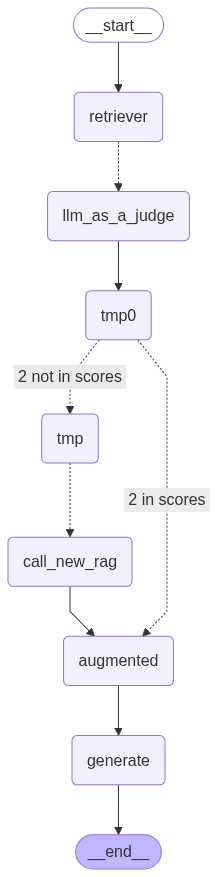

In [6]:
from IPython.display import Image, display

display(Image(rag_with_judge.get_graph(xray=1).draw_mermaid_png()))

In [14]:
# 流式传入运行图的结果
query = input('请输入你的问题：')
log.info(f'用户输入问题：{query}')
for message, metadata in rag_with_judge.stream(
        input={'query': query},  # input 是传递给图的输入
        stream_mode="messages",
        config=run_config
):
    if metadata["langgraph_node"] == "generate":
        print(message.content, end='', flush=True)

2025-06-27 19:16:22.287 | INFO     | __main__:<module>:3 - 用户输入问题：How long did the career span of the actor who starred with Mickey Rooney and Marilyn Maxwell in Off Limits?
2025-06-27 19:16:22.292 | INFO     | NaiveRAG.nodes:retriever_node:29 - ---------- 进入检索模块 ----------
2025-06-27 19:16:22.509 | INFO     | RAGwithJudgeV2.nodes:judge_node:42 - Judge
2025-06-27 19:16:22.512 | INFO     | RAGwithJudgeV2.nodes:judge_node:42 - Judge
2025-06-27 19:16:22.512 | INFO     | RAGwithJudgeV2.nodes:judge_node:42 - Judge
2025-06-27 19:16:25.694 | INFO     | RAGwithJudgeV2.nodes:judge_node:64 - 将 How long did the career span of the actor who starred with Mickey Rooney and Marilyn Maxwell in Off Limits? 和 The Mickey Rooney Show (also known as Hey, Mulligan) is an American sitcom that aired from 1954 to 1955 on NBC. The series stars Mickey Rooney (in his first television role) who was particularly remembered for his starring role in numerous Andy Hardy films made between 1937 and 1958, which overlapp

Bob Hope's career spanned nearly 80 years. [HotpotQA_Bob Hope_5a8ba761554299240d9c2066_p0]

2025-06-27 19:16:35.746 | INFO     | NaiveRAG.nodes:augmented_node:57 - ---------- 进入增强模块 ----------
2025-06-27 19:16:35.750 | INFO     | NaiveRAG.nodes:generate_node:96 - ---------- 进入生成模块 ----------


The career of Bob Hope, who starred with Mickey Rooney and Marilyn Maxwell in Off Limits, spanned nearly 80 years. [HotpotQA_Off Limits (1953 film)_5a8ba761554299240d9c2066_p0]

In [19]:
list(rag_with_judge.get_state_history(config={'configurable': {'thread_id': '1'}}))[0].values['similar_chunks']

[Document(metadata={'title': 'Off Limits (1953 film)', 'dataset': 'HotpotQA', 'start_index': 0, 'pk': 'f9dd8c96-f956-4904-844c-19408360fce6', 'hotpotqa_id': '5a8ba761554299240d9c2066', 'source': 'HotpotQA_Off Limits (1953 film)_5a8ba761554299240d9c2066', 'question': 'How long did the career span of the actor who starred with Mickey Rooney and Marilyn Maxwell in Off Limits?', 'page': 0, 'recursion_depth': 0, 'next_rag_thread_id': 'a7e6eb4f-9627-4398-ab58-e9bcb1f5b35c', 'score': 1, 'reason': '步骤1：问题核心是询问与Mickey Rooney和Marilyn Maxwell共同出演《Off Limits》的演员的职业生涯跨度。步骤2：知识提供了电影的基本信息，包括导演、主演（Bob Hope, Mickey Rooney和Marilyn Maxwell），以及电影的情节简介。步骤3：虽然知识确认了Bob Hope是该电影的主演之一，但没有提供关于他的职业生涯长度的信息。步骤4：因此，这部分知识仅部分有用，因为它回答了谁是主演之一，但没有提供职业生涯跨度的信息。', 'next_query': 'How long was the career span of Bob Hope?'}, page_content="Off Limits is a 1953 comedy film directed by George Marshall and starring Bob Hope, Mickey Rooney and Marilyn Maxwell. Hope plays a manager who enlists in the army to keep an eye on his box

In [21]:
list(rag_with_judge.get_state_history(config={'configurable': {'thread_id': 'a7e6eb4f-9627-4398-ab58-e9bcb1f5b35c'}}))[0].values['similar_chunks']

[Document(metadata={'question': 'How long did the career span of the actor who starred with Mickey Rooney and Marilyn Maxwell in Off Limits?', 'start_index': 0, 'dataset': 'HotpotQA', 'hotpotqa_id': '5a8ba761554299240d9c2066', 'title': 'Bob Hope', 'pk': '596eb1d4-0a69-4493-873d-0f9c224daf7f', 'source': 'HotpotQA_Bob Hope_5a8ba761554299240d9c2066', 'page': 0, 'recursion_depth': 1, 'next_rag_thread_id': '', 'score': 2, 'reason': "Step 1: The question asks for the career span of Bob Hope.\nStep 2: The knowledge states that Bob Hope had a career spanning nearly 80 years.\nStep 3: The provided information directly answers the complete query about the length of Bob Hope's career.\nStep 4: The knowledge is fully useful (2 points) as it comprehensively addresses the question.", 'next_query': ''}, page_content='Bob Hope, KBE, KC*SG, KSS (born Leslie Towns Hope; May 29, 1903 – July 27, 2003) was an American comedian, vaudevillian, actor, singer, dancer, athlete and author. With a career spanning

*2025.06.04*

测试评价指标部分的代码

In [ ]:
def evaluate_qa_pair(prediction, ground_truth):

In [21]:
from typing import Tuple
import collections

def compute_f1_score(prediction: str, ground_truth: str) -> Tuple[float, float, float]:
    """
    计算Token level F1 Score
    
    Args:
        prediction: 预测答案
        ground_truth: 真实答案
        
    Returns:
        Tuple: (F1分数, 精确率, 召回率)
    """
    # 获取token
    prediction_tokens = get_tokens(prediction)
    ground_truth_tokens = get_tokens(ground_truth)
    
    # 如果两者都为空，返回F1=1.0
    if len(prediction_tokens) == 0 and len(ground_truth_tokens) == 0:
        return (1.0, 1.0, 1.0)
    
    # 如果其中一个为空，返回F1=0.0
    if len(prediction_tokens) == 0 or len(ground_truth_tokens) == 0:
        return (0.0, 0.0, 0.0)
    
    # 计算共同的token
    common_tokens = collections.Counter(prediction_tokens) & collections.Counter(ground_truth_tokens)
    num_common = sum(common_tokens.values())
    
    # 如果没有共同token，返回F1=0.0
    if num_common == 0:
        return (0.0, 0.0, 0.0)
    
    # 计算精确率和召回率
    precision = 1.0 * num_common / len(prediction_tokens)
    recall = 1.0 * num_common / len(ground_truth_tokens)
    
    # 计算F1
    f1 = 2 * precision * recall / (precision + recall)
    
    return f1, precision, recall

In [23]:
# 示例 1: 完全匹配
print(compute_f1_score("apple banana", "banana apple"))
# 输出: (1.0, 1.0, 1.0)

# 示例 2: 特殊 case 不匹配
print(compute_f1_score("yes", "no"))
# 输出: (0.0, 0.0, 0.0)

# 示例 3: 一个为空
print(compute_f1_score("", "hello world"))
# 输出: (0.0, 0.0, 0.0)

# 示例 4: 两个都为空
print(compute_f1_score("", ""))
# 输出: (1.0, 1.0, 1.0)

(1.0, 1.0, 1.0)
(0.0, 0.0, 0.0)
(0.0, 0.0, 0.0)
(1.0, 1.0, 1.0)


In [14]:
def compute_exact_match(prediction: str, ground_truth: str) -> float:
    """
    计算精确匹配(EM)分数
    
    Args:
        prediction: 预测答案
        ground_truth: 真实答案
        
    Returns:
        float: EM分数，1.0表示完全匹配，0.0表示不匹配
    """
    return float(normalize_answer(prediction) == normalize_answer(ground_truth))

In [18]:
compute_exact_match("apple and bana na ", "apple and banana")

0.0

In [ ]:
from typing import List
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    nltk.download('punkt_tab')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')


def get_tokens(s: str) -> List[str]:
    """
    获取规范化后的答案中的token列表
    
    Args:
        s: 答案字符串
        
    Returns:
        List[str]: token列表
    """
    # 规范化
    s = normalize_answer(s)
    
    # 分词
    tokens = word_tokenize(s)
    
    # 移除停用词
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    return tokens

In [11]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [12]:
for t_case, ans in test_cases:
    pred = get_tokens(t_case)
    print(f'{pred}, {ans}')

['apple', 'banana'], apple and banana
['quick', 'brown', 'fox'], quick brown fox
['start'], start
['end'], at end
['word'], only word
['sequence'], sequence
['doubled'], doubled
['banana'], and banana
['apple', 'orange'], apple or orange
['hello', 'world', 'end'], hello world end
['quoted', 'text'], quoted text
['extra', 'spaces', 'everywhere'], extra spaces everywhere
['words'], words
['email', 'userexamplecom'], email user@examplecom
['100', 'real'], 100 real
[], 
[], 
[], 
[], 
['dogs', 'toy'], dogs toy


In [13]:
get_tokens("can't")

['cant']

In [1]:
import re
import string

def normalize_answer(s: str) -> str:
    """
    规范化答案字符串，用于评估
    
    Args:
        s: 原始答案字符串
        
    Returns:
        str: 规范化后的答案字符串
    """
    # 转为小写
    s = s.lower()
    
    # 移除标点符号
    s = re.sub(r'[%s]' % re.escape(string.punctuation), '', s)
    
    # 移除文章（a, an, the）
    s = re.sub(r'\b(a|an|the)\b', ' ', s)
    
    # 移除多余空格
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

In [4]:
test_cases = [
    # 简单句子
    ("An apple and a banana", "apple and banana"),
    ("The quick brown fox", "quick brown fox"),
    
    # 开头/结尾冠词
    ("A start", "start"),
    ("At the end the", "at end"),
    ("The only word", "only word"),
    
    # 连续冠词
    ("A an the sequence", "sequence"),
    ("The the doubled", "doubled"),
    
    # 冠词粘连问题修复
    ("and a banana", "and banana"),      # 修复前会变成 "andbanana"
    ("an apple or the orange", "apple or orange"),
    
    # 标点符号处理
    ("Hello, world! The end.", "hello world end"),
    ("'Quoted' text", "quoted text"),
    
    # 空格规范化
    ("  Extra  spaces   everywhere  ", "extra spaces everywhere"),
    ("a\tan\nthe\r\nwords", "words"),
    
    # 特殊字符
    ("Email: user@example.com", "email user@examplecom"),  # 注意：@被移除
    ("100% real", "100 real"),
    
    # 边界情况
    ("a", ""),              # 单个冠词应被移除
    ("the", ""),            # 单个冠词应被移除
    ("", ""),               # 空输入
    (".!?", ""),            # 只有标点
    ("a dog's toy", "dogs toy"),  # 所有格处理
]

wrong_cases = []

for t_case, ans in test_cases:
    pred = normalize_answer(t_case)
    print(f'{pred}, {ans}')
    flag = (pred == ans)
    if not flag:
        wrong_cases.append((t_case, ans, pred))

apple and banana, apple and banana
quick brown fox, quick brown fox
start, start
at end, at end
only word, only word
sequence, sequence
doubled, doubled
and banana, and banana
apple or orange, apple or orange
hello world end, hello world end
quoted text, quoted text
extra spaces everywhere, extra spaces everywhere
words, words
email userexamplecom, email user@examplecom
100 real, 100 real
, 
, 
, 
, 
dogs toy, dogs toy


In [ ]:
# 问题不大
wrong_cases

[('Email: user@example.com', 'email user@examplecom', 'email userexamplecom')]

*2025.06.05*

测试集成后的预处理代码

这个也没什么问题！！！

In [ ]:
import sys

# 需要把当前项目的根目录加到 sys.path 中，才能找到 modules 下的 Index 模块
sys.path.append(r'C:\Users\Lenovo\Desktop\RAG rebuild')

In [43]:
import os
from dotenv import load_dotenv

from langchain_openai import OpenAIEmbeddings

from data_process.open_benchmarks.hotpotqa import get_hotpotqa_vector_store

load_dotenv()

embed_model = OpenAIEmbeddings(
    api_key=os.getenv("BL_API_KEY"),
    base_url=os.getenv("BL_BASE_URL"),
    model="text-embedding-v3",
    dimensions=1024,
    check_embedding_ctx_length=False
)

v_s, v_s_name = get_hotpotqa_vector_store(
    embed_model=embed_model,
    file_path='../data/hotpotqa_10.json',
    sample_size=100,
    vector_store_name='hotpotqa_test',
    chunk_size=700,
    chunk_overlap=10
)

2025-06-04 12:45:08.461 | INFO     | data_process.open_benchmarks.hotpotqa:get_hotpotqa_vector_store:106 - hotpotqa_test 向量数据库已存在，成功加载到内存中


In [45]:
v_s.similarity_search_with_score(
    query='Are the Laleli Mosque and Esma Sultan Mansion located in the same neighborhood?',
    k=5
    )

[(Document(metadata={'pk': 'cdb9be5f-8d0a-4913-a652-b28f1feb1e65', 'hotpotqa_id': '5adbf0a255429947ff17385a', 'question': 'Are the Laleli Mosque and Esma Sultan Mansion located in the same neighborhood?', 'title': 'Laleli Mosque', 'dataset': 'HotpotQA', 'start_index': 0}, page_content='The Laleli Mosque (Turkish: "Laleli Camii, or Tulip Mosque" ) is an 18th-century Ottoman imperial mosque located in Laleli, Fatih, Istanbul, Turkey.'),
  0.6262214183807373),
 (Document(metadata={'pk': 'f9a296e7-d350-4698-af0f-a37436f0f635', 'hotpotqa_id': '5adbf0a255429947ff17385a', 'question': 'Are the Laleli Mosque and Esma Sultan Mansion located in the same neighborhood?', 'title': 'Esma Sultan Mansion', 'dataset': 'HotpotQA', 'start_index': 0}, page_content='The Esma Sultan Mansion (Turkish: "Esma Sultan Yalısı" ), a historical yalı (English: waterside mansion ) located at Bosphorus in Ortaköy neighborhood of Istanbul, Turkey and named after its original owner Esma Sultan, is used today as a cultura

*2025.06.04*

测试预处理 HotpotQA 数据集

OK!!!

In [27]:
# 新增加一个功能：要把随机选择的样本写入一个新的 JSON 文件中，以便后续试验处理
import os
import json

output_path = f'hotpotqa/output_{sample_size}.json'
os.makedirs(os.path.dirname(output_path), exist_ok=True)

with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(raw_data, f, ensure_ascii=False)

In [25]:
from loguru import logger as log
import json

file_path = '../data/hotpotqa_10.json'
sample_size = 100

# 加载原始文件
try:
    with open(file_path, 'r', encoding='utf-8') as f:
        raw_data = json.load(f)
    log.info(f"成功加载HotpotQA数据集，共{len(raw_data)}个样本")
except Exception as e:
    log.error(f"加载HotpotQA数据集失败: {e}")
    raise

2025-06-04 14:58:16.618 | INFO     | __main__:<module>:11 - 成功加载HotpotQA数据集，共10个样本


In [4]:
import random

sample_data = random.sample(raw_data, sample_size) if sample_size < len(raw_data) else raw_data
log.info(f"从数据集中随机抽取了{len(sample_data)}个样本")

2025-06-04 10:06:25.035 | INFO     | __main__:<module>:4 - 从数据集中随机抽取了10个样本


In [5]:
from langchain_core.documents import Document

# 将数据存入 Document 对象中
documents = []
for sample in sample_data:
    # 获取样本的元数据（先这么写）
    sample_id = sample.get('_id', 'unknown_id')
    question = sample.get('question', '')
    context = sample.get('context', ['', []])
    for title, sentences in context:
        # 把句子合并为一个完整的段落（就像 Index 时 PDF 中的一页）
        paragraph = ''.join(sentences)
        doc = Document(
            page_content=paragraph,
            metadata={
                'hotpotqa_id': sample_id,
                'question': question,
                'title': title,
                'dataset': 'HotpotQA'
            }
        )
        documents.append(doc)

In [8]:
import sys
import os
from dotenv import load_dotenv
from langchain_openai import OpenAIEmbeddings

# 需要把当前项目的根目录加到 sys.path 中，才能找到 modules 下的 Index 模块
sys.path.append(r'C:\Users\Lenovo\Desktop\RAG rebuild')

load_dotenv()

embed_model = OpenAIEmbeddings(
    api_key=os.getenv("BL_API_KEY"),
    base_url=os.getenv("BL_BASE_URL"),
    model="text-embedding-v3",
    dimensions=1024,
    check_embedding_ctx_length=False
)

In [29]:
from modules.Index import Index
from langchain_milvus import Milvus
from pymilvus.client.types import LoadState

chunk_size = 700
chunk_overlap = 50
vector_store_name = 'hotpotqa_test'


all_chunks = Index.documents_to_chunks(
    docs=documents,
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
)

# 看要创建的数据库是否已经存在，存在则直接返回向量数据库
# 如果已经存在了一个重名的数据库但没被加载到内存中，则下面的代码会将其加载到内存中
# 如果已经存在了一个重名的数据库并且已经被加载到内存中，则下面的代码只是为对应的向量数据库创建了一个新的引用
vector_store = Milvus(
    embedding_function=embed_model,
    collection_name=vector_store_name
)
client = vector_store.client
state = client.get_load_state(collection_name=vector_store_name)
# 当前的向量数据库还没有被创建过
if state['state'] == LoadState.NotExist:
    pass
else:
    log.info(f'{vector_store_name} 向量数据库已存在，成功加载到内存中')

In [30]:
type(all_chunks), len(all_chunks), all_chunks[0].metadata

(list,
 143,
 {'hotpotqa_id': '5a8b57f25542995d1e6f1371',
  'question': 'Were Scott Derrickson and Ed Wood of the same nationality?',
  'title': 'Ed Wood (film)',
  'dataset': 'HotpotQA',
  'start_index': 0})

In [31]:
for a in all_chunks:
    print(a.page_content, a.metadata['hotpotqa_id'])

Ed Wood is a 1994 American biographical period comedy-drama film directed and produced by Tim Burton, and starring Johnny Depp as cult filmmaker Ed Wood. The film concerns the period in Wood's life when he made his best-known films as well as his relationship with actor Bela Lugosi, played by Martin Landau. Sarah Jessica Parker, Patricia Arquette, Jeffrey Jones, Lisa Marie, and Bill Murray are among the supporting cast. 5a8b57f25542995d1e6f1371
Scott Derrickson (born July 16, 1966) is an American director, screenwriter and producer. He lives in Los Angeles, California. He is best known for directing horror films such as "Sinister", "The Exorcism of Emily Rose", and "Deliver Us From Evil", as well as the 2016 Marvel Cinematic Universe installment, "Doctor Strange." 5a8b57f25542995d1e6f1371
Woodson is a census-designated place (CDP) in Pulaski County, Arkansas, in the United States. Its population was 403 at the 2010 census. It is part of the Little Rock–North Little Rock–Conway Metropol

In [16]:
type(all_chunks[-1])

list

In [33]:
from uuid import uuid4

# 向数据库中添加数据
for i in range(0, len(all_chunks), 10):
    cur_chunks = all_chunks[i : i+10]
    vector_store.add_documents(
        documents=cur_chunks,
        ids=[str(uuid4()) for _ in range(len(cur_chunks))]
    )

In [37]:
vector_store.search_by_metadata(
    expr="title == 'Ed Wood (film)'",
    fields=["text", "hotpotqa_id"],
)

[Document(metadata={'text': "Ed Wood is a 1994 American biographical period comedy-drama film directed and produced by Tim Burton, and starring Johnny Depp as cult filmmaker Ed Wood. The film concerns the period in Wood's life when he made his best-known films as well as his relationship with actor Bela Lugosi, played by Martin Landau. Sarah Jessica Parker, Patricia Arquette, Jeffrey Jones, Lisa Marie, and Bill Murray are among the supporting cast.", 'hotpotqa_id': '5a8b57f25542995d1e6f1371', 'pk': '48f6f786-bcea-4062-abdb-9c96549e0065'}, page_content="Ed Wood is a 1994 American biographical period comedy-drama film directed and produced by Tim Burton, and starring Johnny Depp as cult filmmaker Ed Wood. The film concerns the period in Wood's life when he made his best-known films as well as his relationship with actor Bela Lugosi, played by Martin Landau. Sarah Jessica Parker, Patricia Arquette, Jeffrey Jones, Lisa Marie, and Bill Murray are among the supporting cast.")]

*2025.06.03*

测试带有 LLM as a Judge 模块的 RAG

回答什么的是没有问题的，但是可视化是有问题的。根本没办法通过传入不同的 thread_id 来获得不同的 RAG 调用

In [4]:
import sys

# 需要把当前项目的根目录加到 sys.path 中，才能找到 modules 下的 Index 模块
sys.path.append(r'C:\Users\Lenovo\Desktop\RAG rebuild v2')

In [5]:
import os
from dotenv import load_dotenv
from loguru import logger as log

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langgraph.checkpoint.memory import MemorySaver

from modules.Index import Index
from RAGwithJudge.workflow import get_rag_with_judge_workflow

In [7]:
load_dotenv()

# 1. 定义嵌入模型、聊天模型、向量数据库
embed_model = OpenAIEmbeddings(
    api_key=os.getenv("BL_API_KEY"),
    base_url=os.getenv("BL_BASE_URL"),
    model="text-embedding-v3",
    dimensions=1024,
    check_embedding_ctx_length=False
)

llm = ChatOpenAI(
    api_key=os.getenv("BL_API_KEY"),
    base_url=os.getenv("BL_BASE_URL"),
    model='qwen-max-latest',
    temperature=0.0
)

vs_test1 = Index(
    embed_model=embed_model,
    data_path='../data',
    file_type_wanted={'.pdf'},
    vector_store_name='vs_test1'
)
vs_test1.get_index_done()
vector_store = vs_test1.vector_store

2025-06-26 18:10:22.945 | INFO     | modules.Index:get_index_done:160 - vs_test1 向量数据库已存在，成功加载到内存中


In [8]:
# 2. 定义图相关的配置，包括 为图配置记忆、编译后的图、图的运行时配置
# 为图添加线程级持久化
memory = MemorySaver()
rag_with_judge_wf = get_rag_with_judge_workflow()
rag_with_judge = rag_with_judge_wf.compile(checkpointer=memory)  # 编译图

# 定义运行时配置
run_config = {
    'configurable': {
        'thread_id': '1',  # 持久化图的记忆所需
        'vector_store': vector_store,  # 向量数据库
        'top_k': 3,  # 检索最多返回的文档数
        'llm': llm,  # 使用的 LLM
        'graph': rag_with_judge,  # 递归调用新 RAG 时所需
        # 'workflow': rag_with_judge_wf,
        'recursion_depth': 0,  # 当前递归深度
        'max_rec_depth': 5  # 最大递归深度
    }
}

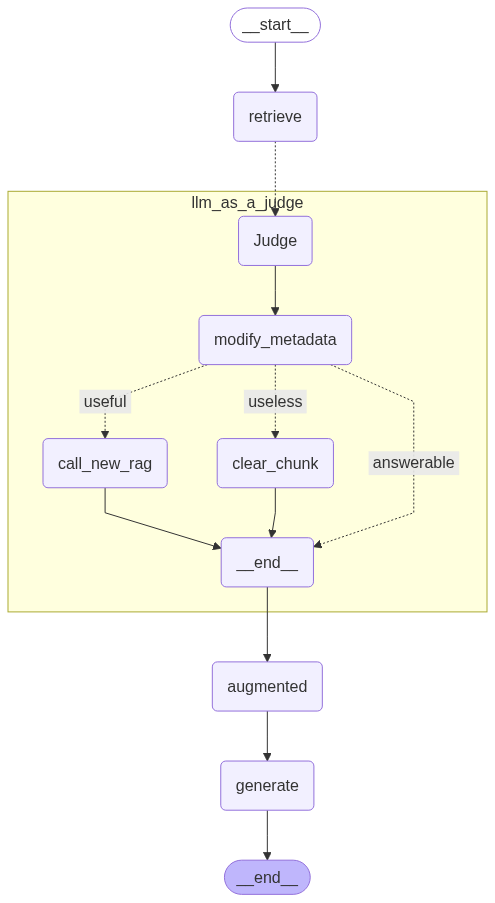

In [9]:
from IPython.display import Image, display

display(Image(rag_with_judge.get_graph(xray=1).draw_mermaid_png()))

In [10]:
# 流式传入运行图的结果
query = input('请输入你的问题：')
log.info(f'用户输入问题：{query}')
for message, metadata in rag_with_judge.stream(
        input={'query': query},  # input 是传递给图的输入
        stream_mode="messages",
        config=run_config
):
    if metadata["langgraph_node"] == "generate":
        print(message.content, end='', flush=True)

2025-06-26 18:11:48.930 | INFO     | __main__:<module>:3 - 用户输入问题：什么是 tool calling
2025-06-26 18:11:48.937 | INFO     | NaiveRAG.nodes:retriever_node:29 - ---------- 进入检索模块 ----------
2025-06-26 18:11:49.276 | INFO     | RAGwithJudge.llm_as_a_judge_node:judge_node:32 - ---------- 进入 Judge 模块 ----------
2025-06-26 18:11:49.286 | INFO     | RAGwithJudge.llm_as_a_judge_node:judge_node:32 - ---------- 进入 Judge 模块 ----------
2025-06-26 18:11:49.287 | INFO     | RAGwithJudge.llm_as_a_judge_node:judge_node:32 - ---------- 进入 Judge 模块 ----------
2025-06-26 18:11:53.050 | INFO     | RAGwithJudge.llm_as_a_judge_node:judge_node:54 - 将 什么是 tool calling 和 Tool calling  
A type of chat model API that accepts tool schemas, along with messages, as 
input and returns invocations of those tools as part of the output message.
❗  PREREQUISITES
Tools
Chat Models
Overview  
许多人工智能应用直接与人类互动。在这些情况下，模型以自然语言做出回应 
是合适的。 
但是如果我们希望模型能够  直接  与系统（例如数据库或  API ）交互，该怎么办 
呢？这些系统通常具有特定的输入模式；例如， APIs frequently have a 
re

A type of chat model API that accepts tool schemas, along with messages, as input and returns invocations of those tools as part of the output message. [4_p0]

2025-06-26 18:12:36.433 | INFO     | NaiveRAG.nodes:augmented_node:57 - ---------- 进入增强模块 ----------
2025-06-26 18:12:36.436 | INFO     | NaiveRAG.nodes:generate_node:96 - ---------- 进入生成模块 ----------


A type of chat model API that accepts tool schemas, along with messages, as input and returns invocations of those tools as part of the output message. [4_p0]

2025-06-26 18:12:38.729 | INFO     | NaiveRAG.nodes:augmented_node:57 - ---------- 进入增强模块 ----------
2025-06-26 18:12:38.733 | INFO     | NaiveRAG.nodes:generate_node:96 - ---------- 进入生成模块 ----------


A type of chat model API that accepts tool schemas, along with messages, as input and returns invocations of those tools as part of the output message. [4_p0]

2025-06-26 18:12:40.672 | INFO     | NaiveRAG.nodes:augmented_node:57 - ---------- 进入增强模块 ----------
2025-06-26 18:12:40.675 | INFO     | NaiveRAG.nodes:generate_node:96 - ---------- 进入生成模块 ----------


A type of chat model API that accepts tool schemas, along with messages, as input and returns invocations of those tools as part of the output message. [4_p0]

2025-06-26 18:12:46.654 | INFO     | NaiveRAG.nodes:augmented_node:57 - ---------- 进入增强模块 ----------
2025-06-26 18:12:46.657 | INFO     | NaiveRAG.nodes:generate_node:96 - ---------- 进入生成模块 ----------


A type of chat model API that accepts tool schemas, along with messages, as input and returns invocations of those tools as part of the output message. [4_p0]

2025-06-26 18:12:49.122 | INFO     | NaiveRAG.nodes:augmented_node:57 - ---------- 进入增强模块 ----------
2025-06-26 18:12:49.128 | INFO     | NaiveRAG.nodes:generate_node:96 - ---------- 进入生成模块 ----------


A type of chat model API that accepts tool schemas, along with messages, as input and returns invocations of those tools as part of the output message. [4_p0]

In [17]:
docs = list(rag_with_judge.get_state_history(config={'configurable': {'thread_id': '1'}}))[0].values['similar_chunks']

In [18]:
docs

[Document(metadata={'pk': '06eef07c-219e-4072-9a51-74112372c0a2', 'source': '../data\\4. Tool calling.pdf', 'page': 0, 'start_index': 0, 'recursion_depth': 0, 'next_rag_thread_id': '', 'score': 2, 'reason': '知识完整解释了tool calling的概念、用途和相关背景信息，完全回答了问题的所有部分', 'remaining_query': ''}, page_content='Tool calling  \nA type of chat model API that accepts tool schemas, along with messages, as \ninput and returns invocations of those tools as part of the output message.\n❗  PREREQUISITES\nTools\nChat Models\nOverview  \n许多人工智能应用直接与人类互动。在这些情况下，模型以自然语言做出回应 \n是合适的。 \n但是如果我们希望模型能够  直接  与系统（例如数据库或  API ）交互，该怎么办 \n呢？这些系统通常具有特定的输入模式；例如， APIs frequently have a \nrequired payload structure。 \n这种需求催生了  tool calling 的概念。您可以使用  tool calling 来请求与特定模式 \n匹配的模型响应（ You can use tool calling to request model responses that \nmatch a particular schema ）。 \n❗  INFO\nfunction calling 在  LangChian 中等价于  tool calling\n\xa0\n💡'),
 Document(metadata={'pk': 'b6bed485-946e-4e86-9eed-86faef133946', 'source': '../data\\4. Too

In [20]:
docs1 = list(rag_with_judge.get_state_history(config={'configurable': {'thread_id': '00fa79f1-8748-4dc6-a1a5-4fc7a4abaf02'}}))[0].values['similar_chunks']
docs1

[Document(metadata={'source': '../data\\4. Tool calling.pdf', 'page': 0, 'start_index': 0, 'pk': '06eef07c-219e-4072-9a51-74112372c0a2', 'recursion_depth': 1, 'next_rag_thread_id': '', 'score': 2, 'reason': 'The knowledge provides a complete definition of tool calling, including its purpose, functionality, and even an equivalence note with function calling in LangChain. This fully answers the question.', 'remaining_query': ''}, page_content='Tool calling  \nA type of chat model API that accepts tool schemas, along with messages, as \ninput and returns invocations of those tools as part of the output message.\n❗  PREREQUISITES\nTools\nChat Models\nOverview  \n许多人工智能应用直接与人类互动。在这些情况下，模型以自然语言做出回应 \n是合适的。 \n但是如果我们希望模型能够  直接  与系统（例如数据库或  API ）交互，该怎么办 \n呢？这些系统通常具有特定的输入模式；例如， APIs frequently have a \nrequired payload structure。 \n这种需求催生了  tool calling 的概念。您可以使用  tool calling 来请求与特定模式 \n匹配的模型响应（ You can use tool calling to request model responses that \nmatch a particular schema ）。 \n❗  INFO\nf

In [23]:
docs2 = list(rag_with_judge.get_state_history(config={'configurable': {'thread_id': '9d8b53aa-f77c-47ce-b709-8f42ba8cc673'}}))[0].values['similar_chunks']
docs2

[Document(metadata={'pk': '06eef07c-219e-4072-9a51-74112372c0a2', 'source': '../data\\4. Tool calling.pdf', 'page': 0, 'start_index': 0, 'recursion_depth': 2, 'next_rag_thread_id': '', 'score': 2, 'reason': "步骤1：问题核心是'tool calling'的定义\n步骤2：知识详细解释了tool calling的概念，包括其工作原理和使用场景\n步骤3：知识完整覆盖了问题的所有要素，提供了准确且完整的定义\n步骤4：符合完全有用标准(2分)", 'remaining_query': ''}, page_content='Tool calling  \nA type of chat model API that accepts tool schemas, along with messages, as \ninput and returns invocations of those tools as part of the output message.\n❗  PREREQUISITES\nTools\nChat Models\nOverview  \n许多人工智能应用直接与人类互动。在这些情况下，模型以自然语言做出回应 \n是合适的。 \n但是如果我们希望模型能够  直接  与系统（例如数据库或  API ）交互，该怎么办 \n呢？这些系统通常具有特定的输入模式；例如， APIs frequently have a \nrequired payload structure。 \n这种需求催生了  tool calling 的概念。您可以使用  tool calling 来请求与特定模式 \n匹配的模型响应（ You can use tool calling to request model responses that \nmatch a particular schema ）。 \n❗  INFO\nfunction calling 在  LangChian 中等价于  tool calling\n\xa0\n💡'),
 Document(metadata={

*2025.06.02*

测试 LLM as a judge 子图

没什么问题

In [1]:
import sys

# 需要把当前项目的根目录加到 sys.path 中，才能找到 modules 下的 Index 模块
sys.path.append(r'C:\Users\Lenovo\Desktop\RAG rebuild')

In [2]:
from RAGwithJudge.llm_as_a_judge_node import get_rag_with_judge_workflow


llm_as_a_judge_wf = get_rag_with_judge_workflow()

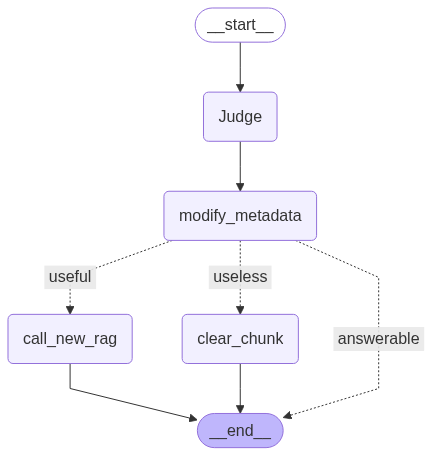

In [3]:
g = llm_as_a_judge_wf.compile()

from IPython.display import Image, display

display(Image(g.get_graph().draw_mermaid_png()))

*2025.06.02*

测试 Judge_node

暂时没什么问题

In [1]:
import sys

# 需要把当前项目的根目录加到 sys.path 中，才能找到 modules 下的 Index 模块
sys.path.append(r'C:\Users\Lenovo\Desktop\RAG rebuild')

In [2]:
from loguru import logger as log
from pydantic import BaseModel, Field
from typing import Literal

from RAGwithJudge.state import JudgeState
from RAGwithJudge.judge_prompt import get_judge_prompt

from langchain_core.runnables import RunnableConfig

In [3]:
from langchain_openai import ChatOpenAI
import os
from dotenv import load_dotenv

from langchain_openai import ChatOpenAI


load_dotenv()

llm = ChatOpenAI(
    api_key=os.getenv("BL_API_KEY"),
    base_url=os.getenv("BL_BASE_URL"),
    model='qwen-max-latest',
    temperature=0.0
)

class JudgeInformation(BaseModel):
    score: Literal[0, 1, 2] = Field(
        description="评分：0=完全无用, 1=部分有用, 2=完全有用"
    )
    reasoning: str = Field(description="推理过程")
    remaining_question: str = Field(
        description="当 score=1（知识部分有用）时改写生成的问题，其他得分时返回空字符串",
        default=''
    )

query = '谁写了《哈姆雷特》？'
similar_chunk = "莎士比亚是英国著名剧作家"
prompt = [get_judge_prompt(query=query, context=similar_chunk)]

llm = llm.with_structured_output(JudgeInformation)

for chunk in llm.stream(prompt):
    print(chunk)

score=1 reasoning='→' remaining_question=''
score=1 reasoning='→ 步骤1：问题' remaining_question=''
score=1 reasoning="→ 步骤1：问题核心是'谁写了《" remaining_question=''
score=1 reasoning="→ 步骤1：问题核心是'谁写了《哈姆雷特》'\n→ 步骤2" remaining_question=''
score=1 reasoning="→ 步骤1：问题核心是'谁写了《哈姆雷特》'\n→ 步骤2：知识提到莎士比亚" remaining_question=''
score=1 reasoning="→ 步骤1：问题核心是'谁写了《哈姆雷特》'\n→ 步骤2：知识提到莎士比亚是剧作家，但" remaining_question=''
score=1 reasoning="→ 步骤1：问题核心是'谁写了《哈姆雷特》'\n→ 步骤2：知识提到莎士比亚是剧作家，但未明确说明他" remaining_question=''
score=1 reasoning="→ 步骤1：问题核心是'谁写了《哈姆雷特》'\n→ 步骤2：知识提到莎士比亚是剧作家，但未明确说明他写了《哈姆" remaining_question=''
score=1 reasoning="→ 步骤1：问题核心是'谁写了《哈姆雷特》'\n→ 步骤2：知识提到莎士比亚是剧作家，但未明确说明他写了《哈姆雷特》\n→" remaining_question=''
score=1 reasoning="→ 步骤1：问题核心是'谁写了《哈姆雷特》'\n→ 步骤2：知识提到莎士比亚是剧作家，但未明确说明他写了《哈姆雷特》\n→ 步骤3：虽然" remaining_question=''
score=1 reasoning="→ 步骤1：问题核心是'谁写了《哈姆雷特》'\n→ 步骤2：知识提到莎士比亚是剧作家，但未明确说明他写了《哈姆雷特》\n→ 步骤3：虽然强烈暗示，但知识并未" remaining_question=''
score=1 reasoning="→ 步骤1：问题核心是'谁写了《哈姆雷特》'\n→ 步骤2：知识提到莎士比亚是剧作家，但未明确说明他写了《哈姆雷特》\n

In [4]:
print(prompt[0].content)

# 角色
你是一个AI信息分析专家，负责严格按以下规则评估知识片段对问题的帮助程度

## 评估标准
1. **完全有用(2分)**：知识能独立且完整地回答问题的所有部分
2. **部分有用(1分)**：知识仅能回答问题的某些部分，但非全部
3. **完全无用(0分)**：知识与问题无关或无法回答任何部分

## 处理规则
1. 执行思考链分析：必须按步骤思考
   → 步骤1：解析问题核心需求
   → 步骤2：提取知识关键信息
   → 步骤3：比对知识覆盖范围
   → 步骤4：确定评分等级
2. 当评分为1（部分有用）时：
   - 必须生成改写后的新问题
   - 新问题需满足：
     a. 仅聚焦原始问题中未被回答的部分
     b. 保持原始问题意图
     c. 使用原始问题中的关键实体
     d. 消除所有代词指代
     e. **不引入**知识中未出现的新信息
     f. 尽量简洁具体
3. 其他评分情况返回空字符串

## 输出格式（严格JSON）
{
  "score": 整数, // 必须是0、1或2
  "reason": "字符串格式的思考过程",
  "remaining_query": "字符串，当且仅当score=1时非空"
}

## 参考示例
示例1 (完全有用 - 2分)
问题："克里斯蒂亚诺·罗纳尔多在曼联效力期间获得了哪些主要个人奖项？"
知识："2008年，效力于曼联的C罗获得了金球奖和欧洲金靴奖。"
思考：
→ 步骤1：问题核心是"曼联期间的主要个人奖项"
→ 步骤2：知识明确提到金球奖和欧洲金靴奖两个主要奖项
→ 步骤3：知识完整覆盖问题所有要素
→ 步骤4：符合完全有用标准(2分)
输出：
{
  "score": 2,
  "reason": "知识完整提供了C罗在曼联期间获得的两项最高个人荣誉",
  "remaining_query": ""
}

示例2 (部分有用 - 1分)
问题："《哈利波特》作者J.K.罗琳的母校是哪所大学？她在那学习了什么专业？"
知识："J.K.罗琳毕业于埃克塞特大学。"
思考：
→ 步骤1：问题有两个子问题：大学名称和专业
→ 步骤2：知识只回答了大学名称(埃克塞特)
→ 步骤3：专业信息完全缺失
→ 步骤4：符合部分有用标准(1分)
输出：
{
  "s

*2025.05.27*

测试 Naive RAG

在传递图的运行时配置时，参数名只能是 `config`，不然 LangGraph 无法解析对应的参数，会报出某个接受 config 的函数缺少一个位置参数的错误。这是因为你在调用图时，是将运行时配置传递到图的 `config` 形参中，自然其他的参数 LangGraph 是解析不了的

其他的没什么了

In [1]:
import sys

# 需要把当前项目的根目录加到 sys.path 中，才能找到 modules 下的 Index 模块
sys.path.append(r'C:\Users\Lenovo\Desktop\RAG rebuild')

In [2]:
import os
from dotenv import load_dotenv
from loguru import logger as log

from modules.Index import Index
from NaiveRAG.workflow import get_naive_rag_workflow

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langgraph.checkpoint.memory import MemorySaver

load_dotenv()

# 1. 定义嵌入模型、聊天模型、向量数据库
embed_model = OpenAIEmbeddings(
    api_key=os.getenv("BL_API_KEY"),
    base_url=os.getenv("BL_BASE_URL"),
    model="text-embedding-v3",
    dimensions=1024,
    check_embedding_ctx_length=False
)

llm = ChatOpenAI(
    api_key=os.getenv("BL_API_KEY"),
    base_url=os.getenv("BL_BASE_URL"),
    model='qwen-max-latest',
    temperature=0.0
)

vs_test1 = Index(
    embed_model=embed_model,
    data_path='../data',
    file_type_wanted={'.pdf'},
    vector_store_name='vs_test1'
)
vs_test1.get_index_done()
vector_store = vs_test1.vector_store

2025-06-03 10:53:20.667 | INFO     | modules.Index:get_index_done:160 - vs_test1 向量数据库已存在，成功加载到内存中


In [3]:
# 2. 定义图相关的配置，包括 为图配置记忆、编译后的图、图的运行时配置
# 为图添加线程级持久化
memory = MemorySaver()
naive_rag_wf = get_naive_rag_workflow()
naive_rag = naive_rag_wf.compile(checkpointer=memory)  # 编译图

# 定义运行时配置
run_config = {
    'configurable': {
        'vector_store': vector_store,
        'top_k': 3,
        'llm': llm,
        'thread_id': '1'
    }
}

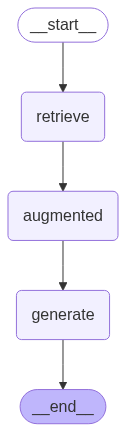

In [4]:
from IPython.display import Image, display

display(Image(naive_rag.get_graph().draw_mermaid_png()))

In [6]:
query = input('请输入你的问题：')
log.info(f'用户输入问题：{query}')

response = naive_rag.invoke(
    input={'query': query},  # input 是传递给图的输入
    config=run_config
)

2025-06-03 10:55:05.217 | INFO     | __main__:<module>:2 - 用户输入问题：什么是 ToolCall
2025-06-03 10:55:05.286 | INFO     | NaiveRAG.nodes:retriever_node:29 - ---------- 进入检索模块 ----------
2025-06-03 10:55:05.511 | INFO     | NaiveRAG.nodes:augmented_node:57 - ---------- 进入增强模块 ----------
2025-06-03 10:55:05.511 | INFO     | NaiveRAG.nodes:generate_node:96 - ---------- 进入生成模块 ----------


In [7]:
response

{'messages': [SystemMessage(content='\n    你是一个基于检索增强生成（RAG）的智能助手，必须严格遵循以下增强工作流程：\n\n    1. **上下文解析规范**\n    - 接收格式化上下文片段（示例：[[文件名_pX] 内容]）\n    - 自动解析元数据格式：`文件名_pX`对应具体文档页码\n    - 对每个片段执行二重有效性验证：\n       - 内容与问题的相关性（0-10分制）\n       - 信息完整性验证（是否包含必要技术细节）\n\n    2. **引用增强规则**\n    - 有效引用必须包含文件标识（格式：[文件名_pX]）\n    - 多来源引用需标注所有相关文件页码（例：[开题报告_p8][开题报告_p9]）\n    - 当同一文件不同页内容相关时，使用范围标注（例：[开题报告_p8-10]）\n\n    3. **响应策略**\n    - 无法定位有效文件引用时立即终止回答\n    - 禁止使用模糊指代（如"相关文档"、"某文件"）\n    - 引用错误率超过20%时自动触发回答终止机制\n\n    4. **输出规范**\n    - 标准响应格式：`答案内容 [开题报告_p8][开题报告_p9]`\n    - 无法回答时使用："对不起，根据提供的文件内容无法回答该问题"\n    ', additional_kwargs={}, response_metadata={}, id='7d0580f4-cca5-4eb5-a7ea-bd584f572458'),
  HumanMessage(content="请仔细阅读、理解下面由<>包围的知识，并使用这些知识来回答用户的提问。\n\n    知识: <['[4_p0] Tool calling  \\nA type of chat model API that accepts tool schemas, along with messages, as \\ninput and returns invocations of those tools as part of the output message.\\n❗  PREREQUISITES\\nTools\\nChat Models\\nOverview

In [8]:
type(response)

langgraph.pregel.io.AddableValuesDict

In [5]:
# 流式传入运行图的结果
query = input('请输入你的问题：')
log.info(f'用户输入问题：{query}')
for message, metadata in naive_rag.stream(
        input={'query': query},  # input 是传递给图的输入
        stream_mode="messages",
        config=run_config
):
    if metadata["langgraph_node"] == "generate":
        print(message.content, end='', flush=True)

2025-05-27 10:17:13.081 | INFO     | __main__:<module>:3 - 用户输入问题：什么是 tool calling
2025-05-27 10:17:13.145 | INFO     | NaiveRAG.nodes:retriever_node:29 - ---------- 进入检索模块 ----------


---------- 进入检索模块 ----------


2025-05-27 10:17:13.429 | INFO     | NaiveRAG.nodes:augmented_node:57 - ---------- 进入增强模块 ----------
2025-05-27 10:17:13.461 | INFO     | NaiveRAG.nodes:generate_node:96 - ---------- 进入生成模块 ----------


---------- 进入增强模块 ----------
---------- 进入生成模块 ----------
Tool calling 是一种聊天模型 API，它接受工具模式（tool schemas）和消息作为输入，并在输出消息中返回这些工具的调用。这个概念的出现是为了解决模型需要与特定系统（例如数据库或 API）直接交互的需求。这些系统通常有特定的输入模式，比如 API 通常需要特定的负载结构。通过 tool calling，可以请求模型生成符合特定模式的响应。简单来说，tool calling 使得模型能够根据输入的相关性决定何时以及如何调用外部工具或函数。这种方法在 LangChain 中也被称为 function calling。

[4_p0][4_p3]

*2025.05.26*

测试 retriever 中的内容

暂时没发现什么问题

In [1]:
# 定义嵌入模型

import os
from dotenv import load_dotenv

from langchain_milvus import Milvus
from langchain_openai import OpenAIEmbeddings

load_dotenv()

embed_model = OpenAIEmbeddings(
    api_key=os.getenv("BL_API_KEY"),
    base_url=os.getenv("BL_BASE_URL"),
    model="text-embedding-v3",
    dimensions=1024,
    check_embedding_ctx_length=False
)

In [2]:
import sys

# 需要把当前项目的根目录加到 sys.path 中，才能找到 modules 下的 Index 模块
sys.path.append(r'C:\Users\Lenovo\Desktop\RAG rebuild')

In [3]:
from modules.Index import Index

# 初始化了一个 Index 实例
vs_test1 = Index(
    embed_model=embed_model,
    data_path='../data',
    file_type_wanted={'.pdf'},
    vector_store_name='vs_test1'
)

In [4]:
vs_test1.get_index_done()

2025-05-26 18:23:53.125 | INFO     | modules.Index:get_index_done:160 - vs_test1 向量数据库已存在，成功加载到内存中


In [ ]:
from modules.retriever import get_similar_chunk_with_score

get_similar_chunk_with_score(
    query='什么是 Tool calling ？',
    vector_store=vs_test1.vector_store,
    top_k=10
)

# 这里的 score 是 distance 的别名，自然越小越好

[(Document(metadata={'start_index': 0, 'pk': '06eef07c-219e-4072-9a51-74112372c0a2', 'source': '../data\\4. Tool calling.pdf', 'page': 0}, page_content='Tool calling  \nA type of chat model API that accepts tool schemas, along with messages, as \ninput and returns invocations of those tools as part of the output message.\n❗  PREREQUISITES\nTools\nChat Models\nOverview  \n许多人工智能应用直接与人类互动。在这些情况下，模型以自然语言做出回应 \n是合适的。 \n但是如果我们希望模型能够  直接  与系统（例如数据库或  API ）交互，该怎么办 \n呢？这些系统通常具有特定的输入模式；例如， APIs frequently have a \nrequired payload structure。 \n这种需求催生了  tool calling 的概念。您可以使用  tool calling 来请求与特定模式 \n匹配的模型响应（ You can use tool calling to request model responses that \nmatch a particular schema ）。 \n❗  INFO\nfunction calling 在  LangChian 中等价于  tool calling\n\xa0\n💡'),
  0.43057388067245483),
 (Document(metadata={'start_index': 0, 'pk': 'b6bed485-946e-4e86-9eed-86faef133946', 'source': '../data\\4. Tool calling.pdf', 'page': 4}, page_content='Tool calling  \n工具调用的一个关键原则是，模型根据输入的相关性决定何时使用工具。模型 \n并不总

*2025.05.26*

测试 Index 模块中的代码

好耶！暂时没发现什么问题

In [1]:
# 定义嵌入模型

import os
from dotenv import load_dotenv

from langchain_milvus import Milvus
from langchain_openai import OpenAIEmbeddings

load_dotenv()

embed_model = OpenAIEmbeddings(
    api_key=os.getenv("BL_API_KEY"),
    base_url=os.getenv("BL_BASE_URL"),
    model="text-embedding-v3",
    dimensions=1024,
    check_embedding_ctx_length=False
)

In [2]:
os.listdir('../data'), os.listdir(r'C:\Users\Lenovo\Desktop\RAG rebuild\data')

(['4. Tool calling.pdf', '6. LCEL.pdf', 'Cognition_Engineering_zh.pdf'],
 ['4. Tool calling.pdf', '6. LCEL.pdf', 'Cognition_Engineering_zh.pdf'])

In [3]:
import sys

sys.path

['d:\\NMK\\Anaconda\\envs\\llm\\python312.zip',
 'd:\\NMK\\Anaconda\\envs\\llm\\DLLs',
 'd:\\NMK\\Anaconda\\envs\\llm\\Lib',
 'd:\\NMK\\Anaconda\\envs\\llm',
 '',
 'd:\\NMK\\Anaconda\\envs\\llm\\Lib\\site-packages',
 'd:\\NMK\\Anaconda\\envs\\llm\\Lib\\site-packages\\win32',
 'd:\\NMK\\Anaconda\\envs\\llm\\Lib\\site-packages\\win32\\lib',
 'd:\\NMK\\Anaconda\\envs\\llm\\Lib\\site-packages\\Pythonwin']

In [4]:
# 需要把当前项目的根目录加到 sys.path 中，才能找到 modules 下的 Index 模块
sys.path.append(r'C:\Users\Lenovo\Desktop\RAG rebuild')

In [5]:
from modules.Index import Index

# 初始化了一个 Index 实例
vs_test1 = Index(
    embed_model=embed_model,
    data_path='../data',
    file_type_wanted={'.pdf'},
    vector_store_name='vs_test1'
)

In [6]:
# 完成创建过程
vs_test1.get_index_done(
    chunk_size=700,
    chunk_overlap=50
)

2025-05-26 17:26:13.019 | INFO     | modules.Index:get_all_file_path:80 - 已获取 3 份文件，忽略 0 份文件
2025-05-26 17:26:13.762 | INFO     | modules.Index:file_to_documents:98 - ../data\4. Tool calling.pdf 完成加载
2025-05-26 17:26:13.765 | INFO     | modules.Index:file_to_documents:98 - ../data\Cognition_Engineering_zh.pdf 完成加载
2025-05-26 17:26:13.765 | INFO     | modules.Index:file_to_documents:98 - ../data\6. LCEL.pdf 完成加载
2025-05-26 17:26:20.470 | INFO     | modules.Index:add_new_files:229 - ../data\4. Tool calling.pdf 被划分为了 16 份 chunk，已存入 vs_test1
2025-05-26 17:26:21.080 | INFO     | modules.Index:add_new_files:229 - ../data\6. LCEL.pdf 被划分为了 9 份 chunk，已存入 vs_test1
2025-05-26 17:26:35.504 | INFO     | modules.Index:add_new_files:229 - ../data\Cognition_Engineering_zh.pdf 被划分为了 266 份 chunk，已存入 vs_test1


In [30]:
a = vs_test1.vector_store.search_by_metadata(
    expr='start_index == 0',
    fields=['text', 'pk', 'source']
)

In [31]:
a

[Document(metadata={'pk': '01683776-91f3-4874-8351-660d32ebe16c', 'source': '../data\\6. LCEL.pdf', 'text': '将  函数  强制转化为  RunnableSequence  \nLCEL 会自动将  函数  转化为  RUnnableSequence\n将  字典  强制转化为  RunnableParallel  \nLCEL 会自动将  字典  转化为  RunnableParallel\n什 么 时 候 应 当 使 用  LCEL  \n建议仅在简单的编排任务中使用  LCEL 。当应用程序需要复杂的状态管理、分 \n支、循环或多个代理时，我们建议用户利用  LangGraph。 \n下面是一些准则： \n如果您要进行单个  LLM 调用，则不需要  LCEL ；而是直接调用底层  聊天模 \n型 。 \n如果您有一个简单的链（例如，提示  + llm + 解析器、简单的检索设置 \n等），那么如果您正在利用  LCEL 的优势，则  LCEL 是一个合理的选择。 \n如果您正在构建一个复杂的链（例如，具有分支、循环、多个代理等），请 \n改用  LangGraph。 请记住，您始终可以在  LangGraph 中的各个节点中使 \n用  LCEL。 \n\xa0\ndef some_func(x):\n    return x\nchain = some_func | runnable1\n# 等价于\nchain = RunnableLambda(some_func) | runnable1\n1\n2\n3\n4\n5\n6\n7\nmapping = {\n    "key1": runnable1,\n    "key2": runnable2,\n}\nchain = mapping | runnable3\n# 等价于'}, page_content='将  函数  强制转化为  RunnableSequence  \nLCEL 会自动将  函数  转化为  RUnnableSequence\n将  字典  强制转化为  RunnableParallel  \nLCEL 会自动将  字典  转化为  RunnableParallel\n什 